As we have a bad data, this project is only for educational purposes

#### Data and Packages


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date 
import os
%matplotlib inline

from sklearn import tree
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [5]:
# Dataset
df = pd.read_csv("data.csv", encoding = 'latin1')

In [6]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
df = df[df['CustomerID'].notna()]

In [8]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [9]:
dt = df

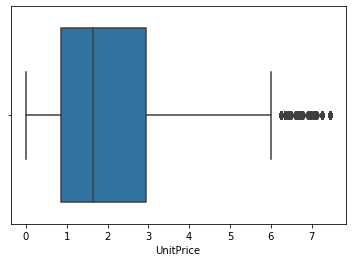

In [10]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out
dt = remove_outlier(dt,'UnitPrice')
sns.boxplot(x=dt['UnitPrice'])

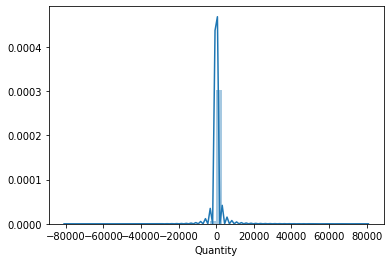

In [11]:
sns.distplot(df.Quantity)

In [12]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [18]:
df.shape

(406829, 8)

#### Feature Engineering

In [19]:
purch_hist = df[(df.InvoiceDate < '2011-08-01') & 
                  (df.InvoiceDate >= '2010-12-01')]
purch_next = df[(df.InvoiceDate >= '2011-08-01') & 
                  (df.InvoiceDate < '2011-12-09')].reset_index(drop=True)

In [20]:
customer  = pd.DataFrame(purch_hist['CustomerID'].unique())
customer.columns = ['CustomerID']

In [21]:
purch_hist.shape, purch_next.shape, customer.shape

next_ = purch_next.groupby('CustomerID').InvoiceDate.min().reset_index()
next_.columns = ['CustomerID','MinPurchaseDate']
next_.head()

CustomerID     MinPurchaseDate
0     12347.0 2011-08-02 08:48:00
1     12348.0 2011-09-25 13:13:00
2     12349.0 2011-11-21 09:51:00
3     12352.0 2011-09-20 14:34:00
4     12356.0 2011-11-17 08:40:00

In [22]:
purch_hist.shape, purch_next.shape, customer.shape

((204391, 8), (201814, 8), (3193, 1))

In [23]:
last_ = purch_hist.groupby('CustomerID').InvoiceDate.max().reset_index()
last_.columns = ['CustomerID','MaxPurchaseDate']
purchase = pd.merge(last_, next_,on='CustomerID',how='left')
purchase['NextPurchaseDay'] = (purchase['MinPurchaseDate'] - purchase['MaxPurchaseDate']).dt.days
purchase.head()

CustomerID     MaxPurchaseDate     MinPurchaseDate  NextPurchaseDay
0     12346.0 2011-01-18 10:17:00                 NaT              NaN
1     12347.0 2011-06-09 13:01:00 2011-08-02 08:48:00             53.0
2     12348.0 2011-04-05 10:47:00 2011-09-25 13:13:00            173.0
3     12350.0 2011-02-02 16:01:00                 NaT              NaN
4     12352.0 2011-03-22 16:08:00 2011-09-20 14:34:00            181.0

In [24]:
customer = pd.merge(customer, purchase[['CustomerID','NextPurchaseDay']],on='CustomerID',how='left')
print('Number of retained customers: ', customer.NextPurchaseDay.notna().sum())
customer = customer.fillna(999)
customer.shape

Number of retained customers:  2032


(3193, 2)

##### Adding new features

In [25]:
day_order = purch_hist[['CustomerID','InvoiceDate']]
day_order = day_order.sort_values(['CustomerID','InvoiceDate'])
day_order = day_order.drop_duplicates(subset=['CustomerID','InvoiceDate'],keep='first')

# last 3 purchase dates
day_order['Previous'] = day_order.groupby('CustomerID')['InvoiceDate'].shift(1)
day_order['Previous2'] = day_order.groupby('CustomerID')['InvoiceDate'].shift(2)
day_order['Previous3'] = day_order.groupby('CustomerID')['InvoiceDate'].shift(3)

In [26]:
day_order.head(10)

CustomerID         InvoiceDate            Previous  \
61619      12346.0 2011-01-18 10:01:00                 NaT   
61624      12346.0 2011-01-18 10:17:00 2011-01-18 10:01:00   
14938      12347.0 2010-12-07 14:57:00                 NaT   
72246      12347.0 2011-01-26 14:30:00 2010-12-07 14:57:00   
148285     12347.0 2011-04-07 10:43:00 2011-01-26 14:30:00   
220572     12347.0 2011-06-09 13:01:00 2011-04-07 10:43:00   
34083      12348.0 2010-12-16 19:09:00                 NaT   
70051      12348.0 2011-01-25 10:42:00 2010-12-16 19:09:00   
146013     12348.0 2011-04-05 10:47:00 2011-01-25 10:42:00   
80323      12350.0 2011-02-02 16:01:00                 NaT   

                 Previous2           Previous3  
61619                  NaT                 NaT  
61624                  NaT                 NaT  
14938                  NaT                 NaT  
72246                  NaT                 NaT  
148285 2010-12-07 14:57:00                 NaT  
220572 2011-01-26 14:30:00 2010-12-07 14:57:00  
34083                  NaT                 NaT  
70051                  NaT                 NaT  
146013 2010-12-16 19:09:00                 NaT  
80323                  NaT                 NaT

In [27]:
day_order['DayDiff'] = (day_order['InvoiceDate'] - day_order['Previous']).dt.days
day_order['DayDiff2'] = (day_order['InvoiceDate'] - day_order['Previous2']).dt.days
day_order['DayDiff3'] = (day_order['InvoiceDate'] - day_order['Previous3']).dt.days
day_order.head(10)

CustomerID         InvoiceDate            Previous  \
61619      12346.0 2011-01-18 10:01:00                 NaT   
61624      12346.0 2011-01-18 10:17:00 2011-01-18 10:01:00   
14938      12347.0 2010-12-07 14:57:00                 NaT   
72246      12347.0 2011-01-26 14:30:00 2010-12-07 14:57:00   
148285     12347.0 2011-04-07 10:43:00 2011-01-26 14:30:00   
220572     12347.0 2011-06-09 13:01:00 2011-04-07 10:43:00   
34083      12348.0 2010-12-16 19:09:00                 NaT   
70051      12348.0 2011-01-25 10:42:00 2010-12-16 19:09:00   
146013     12348.0 2011-04-05 10:47:00 2011-01-25 10:42:00   
80323      12350.0 2011-02-02 16:01:00                 NaT   

                 Previous2           Previous3  DayDiff  DayDiff2  DayDiff3  
61619                  NaT                 NaT      NaN       NaN       NaN  
61624                  NaT                 NaT      0.0       NaN       NaN  
14938                  NaT                 NaT      NaN       NaN       NaN  
72246                  NaT                 NaT     49.0       NaN       NaN  
148285 2010-12-07 14:57:00                 NaT     70.0     120.0       NaN  
220572 2011-01-26 14:30:00 2010-12-07 14:57:00     63.0     133.0     183.0  
34083                  NaT                 NaT      NaN       NaN       NaN  
70051                  NaT                 NaT     39.0       NaN       NaN  
146013 2010-12-16 19:09:00                 NaT     70.0     109.0       NaN  
80323                  NaT                 NaT      NaN       NaN       NaN

In [28]:
day_diff = day_order.groupby('CustomerID').agg({'DayDiff': ['mean','std']}).reset_index()
day_diff.columns = ['CustomerID', 'DayDiffMean','DayDiffStd']
day_diff.head()

CustomerID  DayDiffMean  DayDiffStd
0     12346.0     0.000000         NaN
1     12347.0    60.666667   10.692677
2     12348.0    54.500000   21.920310
3     12350.0          NaN         NaN
4     12352.0     4.857143    6.890297

In [29]:
last_day = day_order.drop_duplicates(subset=['CustomerID'],keep='last')
last_day.head(5)

CustomerID         InvoiceDate            Previous  \
61624      12346.0 2011-01-18 10:17:00 2011-01-18 10:01:00   
220572     12347.0 2011-06-09 13:01:00 2011-04-07 10:43:00   
146013     12348.0 2011-04-05 10:47:00 2011-01-25 10:42:00   
80323      12350.0 2011-02-02 16:01:00                 NaT   
129781     12352.0 2011-03-22 16:08:00 2011-03-22 16:07:00   

                 Previous2           Previous3  DayDiff  DayDiff2  DayDiff3  
61624                  NaT                 NaT      0.0       NaN       NaN  
220572 2011-01-26 14:30:00 2010-12-07 14:57:00     63.0     133.0     183.0  
146013 2010-12-16 19:09:00                 NaT     70.0     109.0       NaN  
80323                  NaT                 NaT      NaN       NaN       NaN  
129781 2011-03-17 16:00:00 2011-03-01 15:52:00      0.0       5.0      21.0

In [30]:
last_day = pd.merge(last_day, day_diff, on='CustomerID')
customer = pd.merge(customer, last_day[['CustomerID','DayDiff','DayDiffMean','DayDiffStd']], on='CustomerID')
customer = customer.fillna(0)

customer.head()
len(customer)
# USE 'DayDiff2','DayDiff3' in case you have more data

3193

In [31]:
other_features = df.groupby('CustomerID', as_index=False).agg({'UnitPrice':'mean',
                                                                   'Quantity':'mean'})

In [32]:
other_categories = df.drop_duplicates(subset=['CustomerID'], keep = 'last')
other = pd.merge(other_features,other_categories, on = 'CustomerID', how = 'left')


###### Creating 3 different final data


In [33]:
final = pd.merge(customer, other, on= 'CustomerID', how = 'left')

final.set_index('CustomerID', inplace=True)
final.head()

NextPurchaseDay  DayDiff  DayDiffMean  DayDiffStd  UnitPrice_x  \
CustomerID                                                                   
17850.0               999.0     69.0     2.090909   12.011358     3.924712   
13047.0                27.0     18.0    23.888889   19.656071     4.072959   
12583.0                48.0     16.0    27.000000   21.400935     3.152510   
13748.0               136.0     14.0    70.500000   79.903066     3.996429   
15100.0               999.0      3.0     8.200000    9.338094    10.950000   

            Quantity_x InvoiceNo StockCode                      Description  \
CustomerID                                                                    
17850.0       5.426282   C543611     21169  YOU'RE CONFUSING ME METAL SIGN    
13047.0       6.913265   C575047         M                           Manual   
12583.0      19.956175    581001     22726       ALARM CLOCK BAKELIKE GREEN   
13748.0      15.678571    565464     23012  GLASS APOTHECARY BOTTLE PERFUME   
15100.0       9.666667   C541117     21258       VICTORIAN SEWING BOX LARGE   

            Quantity_y         InvoiceDate  UnitPrice_y         Country  
CustomerID                                                               
17850.0             -2 2011-02-10 14:38:00         1.45  United Kingdom  
13047.0             -1 2011-11-08 12:10:00        14.95  United Kingdom  
12583.0             24 2011-12-07 08:07:00         3.75          France  
13748.0              4 2011-09-05 09:45:00         3.95  United Kingdom  
15100.0             -3 2011-01-13 17:09:00        10.95  United Kingdom

In [34]:
final1 = final.drop(["InvoiceNo",'Country',"Description","StockCode"], axis = 1)
final1

NextPurchaseDay  DayDiff  DayDiffMean  DayDiffStd  UnitPrice_x  \
CustomerID                                                                   
17850.0               999.0     69.0     2.090909   12.011358     3.924712   
13047.0                27.0     18.0    23.888889   19.656071     4.072959   
12583.0                48.0     16.0    27.000000   21.400935     3.152510   
13748.0               136.0     14.0    70.500000   79.903066     3.996429   
15100.0               999.0      3.0     8.200000    9.338094    10.950000   
15291.0                77.0      0.0    13.000000   18.757855     5.056606   
14688.0                12.0      8.0    15.066667   12.515514     2.098050   
17809.0                15.0     23.0    28.250000   26.228392    14.018594   
15311.0                 4.0      2.0     2.808219    3.156376     2.516158   
14527.0                 5.0      1.0     4.000000    3.751543     5.931395   
16098.0                29.0     27.0    42.600000   29.711950     4.424627   
18074.0               999.0      0.0     0.000000    0.000000     4.780769   
17420.0               120.0    202.0   202.000000    0.000000     3.881333   
16029.0                 7.0      0.0     5.209302    5.837311    87.996861   
16250.0               999.0    112.0   112.000000    0.000000     3.088333   
12431.0                17.0      0.0    19.333333   22.812809     3.758333   
17511.0                14.0     14.0     7.821429    9.213732     2.422937   
17548.0               999.0     15.0    77.500000   88.388348     1.974706   
13705.0               137.0    228.0   228.000000    0.000000     7.608571   
13747.0               999.0      0.0     0.000000    0.000000     9.950000   
13408.0                 6.0      3.0     5.625000    5.912557     3.222555   
13767.0                 9.0      6.0     6.500000    8.525363     3.747820   
17924.0               230.0      3.0    18.250000   23.599082     3.447368   
13448.0               132.0      5.0    26.500000   56.684213     3.193367   
15862.0                92.0    169.0   169.000000    0.000000     2.737891   
15513.0                30.0     39.0    16.571429   15.873123     4.122548   
12791.0               999.0      0.0     0.000000    0.000000     8.425000   
16218.0                23.0     46.0    46.600000   44.517412     1.751444   
14045.0               228.0      0.0    17.500000   24.748737     4.233333   
14307.0                45.0     84.0    79.000000   27.838822     2.486444   
...                     ...      ...          ...         ...          ...   
15261.0               999.0      0.0     0.000000    0.000000     1.199474   
15105.0                48.0      0.0     0.000000    0.000000     2.410792   
13813.0                 8.0      0.0     0.000000    0.000000     4.351408   
18268.0               999.0      0.0     0.000000    0.000000    12.750000   
14855.0                15.0      0.0     0.000000    0.000000     4.670000   
13925.0                13.0      0.0     0.000000    0.000000     6.757556   
18237.0                14.0      0.0     0.000000    0.000000     2.957705   
12453.0               999.0      0.0     0.000000    0.000000     2.393256   
15639.0               999.0      0.0     0.000000    0.000000     4.308400   
15118.0               999.0      0.0     0.000000    0.000000     0.170000   
15746.0               999.0      0.0     0.000000    0.000000     1.442414   
12743.0               999.0      0.0     0.000000    0.000000     3.038582   
15942.0               999.0      0.0     0.000000    0.000000     2.657857   
14143.0               999.0      0.0     0.000000    0.000000     5.485714   
15120.0                 4.0      0.0     0.000000    0.000000     4.866364   
16147.0               999.0      0.0     0.000000    0.000000     3.910455   
13277.0                17.0      0.0     0.000000    0.000000     1.450000   
18127.0               114.0      0.0     0.000000    0.000000     3.177447   
15149.0               999.0      0

In [35]:
final2 = final1.drop(["Quantity_x","UnitPrice_x","UnitPrice_y","Quantity_y"], axis = 1)
final2

NextPurchaseDay  DayDiff  DayDiffMean  DayDiffStd  \
CustomerID                                                      
17850.0               999.0     69.0     2.090909   12.011358   
13047.0                27.0     18.0    23.888889   19.656071   
12583.0                48.0     16.0    27.000000   21.400935   
13748.0               136.0     14.0    70.500000   79.903066   
15100.0               999.0      3.0     8.200000    9.338094   
15291.0                77.0      0.0    13.000000   18.757855   
14688.0                12.0      8.0    15.066667   12.515514   
17809.0                15.0     23.0    28.250000   26.228392   
15311.0                 4.0      2.0     2.808219    3.156376   
14527.0                 5.0      1.0     4.000000    3.751543   
16098.0                29.0     27.0    42.600000   29.711950   
18074.0               999.0      0.0     0.000000    0.000000   
17420.0               120.0    202.0   202.000000    0.000000   
16029.0                 7.0      0.0     5.209302    5.837311   
16250.0               999.0    112.0   112.000000    0.000000   
12431.0                17.0      0.0    19.333333   22.812809   
17511.0                14.0     14.0     7.821429    9.213732   
17548.0               999.0     15.0    77.500000   88.388348   
13705.0               137.0    228.0   228.000000    0.000000   
13747.0               999.0      0.0     0.000000    0.000000   
13408.0                 6.0      3.0     5.625000    5.912557   
13767.0                 9.0      6.0     6.500000    8.525363   
17924.0               230.0      3.0    18.250000   23.599082   
13448.0               132.0      5.0    26.500000   56.684213   
15862.0                92.0    169.0   169.000000    0.000000   
15513.0                30.0     39.0    16.571429   15.873123   
12791.0               999.0      0.0     0.000000    0.000000   
16218.0                23.0     46.0    46.600000   44.517412   
14045.0               228.0      0.0    17.500000   24.748737   
14307.0                45.0     84.0    79.000000   27.838822   
...                     ...      ...          ...         ...   
15261.0               999.0      0.0     0.000000    0.000000   
15105.0                48.0      0.0     0.000000    0.000000   
13813.0                 8.0      0.0     0.000000    0.000000   
18268.0               999.0      0.0     0.000000    0.000000   
14855.0                15.0      0.0     0.000000    0.000000   
13925.0                13.0      0.0     0.000000    0.000000   
18237.0                14.0      0.0     0.000000    0.000000   
12453.0               999.0      0.0     0.000000    0.000000   
15639.0               999.0      0.0     0.000000    0.000000   
15118.0               999.0      0.0     0.000000    0.000000   
15746.0               999.0      0.0     0.000000    0.000000   
12743.0               999.0      0.0     0.000000    0.000000   
15942.0               999.0      0.0     0.000000    0.000000   
14143.0               999.0      0.0     0.000000    0.000000   
15120.0                 4.0      0.0     0.000000    0.000000   
16147.0               999.0      0.0     0.000000    0.000000   
13277.0                17.0      0.0     0.000000    0.000000   
18127.0               114.0      0.0     0.000000    0.000000   
15149.0               999.0      0.0     0.000000    0.000000   
18081.0                21.0      0.0     0.000000    0.000000   
14511.0                41.0      0.0     0.000000    0.000000   
12716.0               129.0      0.0     0.000000    0.000000   
15776.0               999.0      0.0     0.000000    0.000000   
12981.0               103.0      0.0     0.000000    0.000000   
13106.0                 4.0      0.0     0.000000    0.000000   
13928.0                26.0      0.0     0.000000    0.000000   
14885.0               999.0      0.0     0.000000    0.000000   
13388.0                10.0      0.0     0.000000    0.000000   
15438.0               999.0      0.0     0.0000

In [36]:
final = pd.get_dummies(final)
final1 = pd.get_dummies(final1)
final2 = pd.get_dummies(final2)
final.head()

NextPurchaseDay  DayDiff  DayDiffMean  DayDiffStd  UnitPrice_x  \
CustomerID                                                                   
17850.0               999.0     69.0     2.090909   12.011358     3.924712   
13047.0                27.0     18.0    23.888889   19.656071     4.072959   
12583.0                48.0     16.0    27.000000   21.400935     3.152510   
13748.0               136.0     14.0    70.500000   79.903066     3.996429   
15100.0               999.0      3.0     8.200000    9.338094    10.950000   

            Quantity_x  Quantity_y         InvoiceDate  UnitPrice_y  \
CustomerID                                                            
17850.0       5.426282          -2 2011-02-10 14:38:00         1.45   
13047.0       6.913265          -1 2011-11-08 12:10:00        14.95   
12583.0      19.956175          24 2011-12-07 08:07:00         3.75   
13748.0      15.678571           4 2011-09-05 09:45:00         3.95   
15100.0       9.666667          -3 2011-01-13 17:09:00        10.95   

            InvoiceNo_536384  ...  Country_Portugal  Country_Saudi Arabia  \
CustomerID                    ...                                           
17850.0                    0  ...                 0                     0   
13047.0                    0  ...                 0                     0   
12583.0                    0  ...                 0                     0   
13748.0                    0  ...                 0                     0   
15100.0                    0  ...                 0                     0   

            Country_Singapore  Country_Spain  Country_Sweden  \
CustomerID                                                     
17850.0                     0              0               0   
13047.0                     0              0               0   
12583.0                     0              0               0   
13748.0                     0              0               0   
15100.0                     0              0               0   

            Country_Switzerland  Country_USA  Country_United Arab Emirates  \
CustomerID                                                                   
17850.0                       0            0                             0   
13047.0                       0            0                             0   
12583.0                       0            0                             0   
13748.0                       0            0                             0   
15100.0                       0            0                             0   

            Country_United Kingdom  Country_Unspecified  
CustomerID                                               
17850.0                          1                    0  
13047.0                          1                    0  
12583.0                          0                    0  
13748.0                          1                    0  
15100.0                          1                    0  

[5 rows x 5789 columns]

In [37]:
final.NextPurchaseDay.describe()

count    3193.000000
mean      434.497964
std       431.620601
min         1.000000
25%        75.000000
50%       171.000000
75%       999.000000
max       999.000000
Name: NextPurchaseDay, dtype: float64

In [38]:
final['NextPurchase'] = 2 # till 279 days
final.loc[final.NextPurchaseDay>100,'NextPurchase'] = 1 #till 998 days
final.loc[final.NextPurchaseDay>998,'NextPurchase'] = 0 #never retained

In [39]:
final.NextPurchase.value_counts()/len(customer)*100 

0    36.360789
2    33.573442
1    30.065769
Name: NextPurchase, dtype: float64

In [40]:
final1['NextPurchase'] = 2 # till 279 days
final1.loc[final1.NextPurchaseDay>100,'NextPurchase'] = 1 #till 998 days
final1.loc[final1.NextPurchaseDay>998,'NextPurchase'] = 0 #never retained
final1.NextPurchase.value_counts()/len(customer)*100 

0    36.360789
2    33.573442
1    30.065769
Name: NextPurchase, dtype: float64

In [41]:
final2['NextPurchase'] = 2 # till 279 days
final2.loc[final2.NextPurchaseDay>100,'NextPurchase'] = 1 #till 998 days
final2.loc[final2.NextPurchaseDay>998,'NextPurchase'] = 0 #never retained
final2.NextPurchase.value_counts()/len(customer)*100 

0    36.360789
2    33.573442
1    30.065769
Name: NextPurchase, dtype: float64

In [42]:
final.NextPurchase.describe()

count    3193.000000
mean        0.972127
std         0.835933
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: NextPurchase, dtype: float64

In [43]:
final = final.drop(columns=['NextPurchaseDay','InvoiceDate'])
final1 = final1.drop(columns=['NextPurchaseDay','InvoiceDate'])
final2 = final2.drop(columns=['NextPurchaseDay','InvoiceDate'])

In [44]:
final2

DayDiff  DayDiffMean  DayDiffStd  NextPurchase
CustomerID                                                
17850.0        69.0     2.090909   12.011358             0
13047.0        18.0    23.888889   19.656071             2
12583.0        16.0    27.000000   21.400935             2
13748.0        14.0    70.500000   79.903066             1
15100.0         3.0     8.200000    9.338094             0
15291.0         0.0    13.000000   18.757855             2
14688.0         8.0    15.066667   12.515514             2
17809.0        23.0    28.250000   26.228392             2
15311.0         2.0     2.808219    3.156376             2
14527.0         1.0     4.000000    3.751543             2
16098.0        27.0    42.600000   29.711950             2
18074.0         0.0     0.000000    0.000000             0
17420.0       202.0   202.000000    0.000000             1
16029.0         0.0     5.209302    5.837311             2
16250.0       112.0   112.000000    0.000000             0
12431.0         0.0    19.333333   22.812809             2
17511.0        14.0     7.821429    9.213732             2
17548.0        15.0    77.500000   88.388348             0
13705.0       228.0   228.000000    0.000000             1
13747.0         0.0     0.000000    0.000000             0
13408.0         3.0     5.625000    5.912557             2
13767.0         6.0     6.500000    8.525363             2
17924.0         3.0    18.250000   23.599082             1
13448.0         5.0    26.500000   56.684213             1
15862.0       169.0   169.000000    0.000000             2
15513.0        39.0    16.571429   15.873123             2
12791.0         0.0     0.000000    0.000000             0
16218.0        46.0    46.600000   44.517412             2
14045.0         0.0    17.500000   24.748737             1
14307.0        84.0    79.000000   27.838822             2
...             ...          ...         ...           ...
15261.0         0.0     0.000000    0.000000             0
15105.0         0.0     0.000000    0.000000             2
13813.0         0.0     0.000000    0.000000             2
18268.0         0.0     0.000000    0.000000             0
14855.0         0.0     0.000000    0.000000             2
13925.0         0.0     0.000000    0.000000             2
18237.0         0.0     0.000000    0.000000             2
12453.0         0.0     0.000000    0.000000             0
15639.0         0.0     0.000000    0.000000             0
15118.0         0.0     0.000000    0.000000             0
15746.0         0.0     0.000000    0.000000             0
12743.0         0.0     0.000000    0.000000             0
15942.0         0.0     0.000000    0.000000             0
14143.0         0.0     0.000000    0.000000             0
15120.0         0.0     0.000000    0.000000             2
16147.0         0.0     0.000000    0.000000             0
13277.0         0.0     0.000000    0.000000             2
18127.0         0.0     0.000000    0.000000             1
15149.0         0.0     0.000000    0.000000             0
18081.0         0.0     0.000000    0.000000             2
14511.0         0.0     0.000000    0.000000             2
12716.0         0.0     0.000000    0.000000             1
15776.0         0.0     0.000000    0.000000             0
12981.0         0.0     0.000000    0.000000             1
13106.0         0.0     0.000000    0.000000             2
13928.0         0.0     0.000000    0.000000             2
14885.0         0.0     0.000000    0.000000             0
13388.0         0.0     0.000000    0.000000             2
15438.0         0.0     0.000000    0.000000             0
17173.0         0.0     0.000000    0.000000             2

[3193 rows x 4 columns]

#### Modeling

In [45]:
X, y = final2.drop('NextPurchase',axis=1), final2.NextPurchase
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [46]:
X

DayDiff  DayDiffMean  DayDiffStd
CustomerID                                  
17850.0        69.0     2.090909   12.011358
13047.0        18.0    23.888889   19.656071
12583.0        16.0    27.000000   21.400935
13748.0        14.0    70.500000   79.903066
15100.0         3.0     8.200000    9.338094
15291.0         0.0    13.000000   18.757855
14688.0         8.0    15.066667   12.515514
17809.0        23.0    28.250000   26.228392
15311.0         2.0     2.808219    3.156376
14527.0         1.0     4.000000    3.751543
16098.0        27.0    42.600000   29.711950
18074.0         0.0     0.000000    0.000000
17420.0       202.0   202.000000    0.000000
16029.0         0.0     5.209302    5.837311
16250.0       112.0   112.000000    0.000000
12431.0         0.0    19.333333   22.812809
17511.0        14.0     7.821429    9.213732
17548.0        15.0    77.500000   88.388348
13705.0       228.0   228.000000    0.000000
13747.0         0.0     0.000000    0.000000
13408.0         3.0     5.625000    5.912557
13767.0         6.0     6.500000    8.525363
17924.0         3.0    18.250000   23.599082
13448.0         5.0    26.500000   56.684213
15862.0       169.0   169.000000    0.000000
15513.0        39.0    16.571429   15.873123
12791.0         0.0     0.000000    0.000000
16218.0        46.0    46.600000   44.517412
14045.0         0.0    17.500000   24.748737
14307.0        84.0    79.000000   27.838822
...             ...          ...         ...
15261.0         0.0     0.000000    0.000000
15105.0         0.0     0.000000    0.000000
13813.0         0.0     0.000000    0.000000
18268.0         0.0     0.000000    0.000000
14855.0         0.0     0.000000    0.000000
13925.0         0.0     0.000000    0.000000
18237.0         0.0     0.000000    0.000000
12453.0         0.0     0.000000    0.000000
15639.0         0.0     0.000000    0.000000
15118.0         0.0     0.000000    0.000000
15746.0         0.0     0.000000    0.000000
12743.0         0.0     0.000000    0.000000
15942.0         0.0     0.000000    0.000000
14143.0         0.0     0.000000    0.000000
15120.0         0.0     0.000000    0.000000
16147.0         0.0     0.000000    0.000000
13277.0         0.0     0.000000    0.000000
18127.0         0.0     0.000000    0.000000
15149.0         0.0     0.000000    0.000000
18081.0         0.0     0.000000    0.000000
14511.0         0.0     0.000000    0.000000
12716.0         0.0     0.000000    0.000000
15776.0         0.0     0.000000    0.000000
12981.0         0.0     0.000000    0.000000
13106.0         0.0     0.000000    0.000000
13928.0         0.0     0.000000    0.000000
14885.0         0.0     0.000000    0.000000
13388.0         0.0     0.000000    0.000000
15438.0         0.0     0.000000    0.000000
17173.0         0.0     0.000000    0.000000

[3193 rows x 3 columns]

# GridSearchCV


In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [48]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       scoring_test=r2_score, do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    best_model = fitted_model.best_estimator_
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    score = scoring_test(y_test_data, pred)
    
    return [best_model, pred, score]

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Defining our estimator, the algorithm to optimize
models_to_train = [RandomForestClassifier(), GradientBoostingClassifier(),KNeighborsClassifier()]

# Defining the hyperparameters to optimize
grid_parameters = [
    { # RandomForest
        'n_estimators': [50, 150, 250],
        'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
        'min_samples_split': [2, 4, 6]
    },
    { # GradientBoosting
        "loss":["deviance"],
        "learning_rate": [ 0.075, 0.15, 0.2],
        "min_samples_split": np.linspace(0.1, 0.5, 5),
        "min_samples_leaf": np.linspace(0.1, 0.5, 5),
        "max_depth":[3,5,8],
        "max_features":["log2","sqrt"],
        "criterion": ["friedman_mse",  "mae"],
        "subsample":[0.7,  0.85, 1.0],
        "n_estimators":[10]
    },
    { # Kneighborhood
        'n_neighbors':[4,5,6,7],
        'leaf_size':[1,3,5],
        'algorithm':['auto', 'kd_tree'],
        'n_jobs':[-1]
    }
]

In [54]:
models_preds_scores = []

for i, model in enumerate(models_to_train):
    params = grid_parameters[i]
    
    result = algorithm_pipeline(X_train, X_test, y_train, y_test, 
                                 model, params, cv=5)
    models_preds_scores.append(result)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  1.0min finished


Fitting 5 folds for each of 2700 candidates, totalling 13500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 1432 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 2564 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4024 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 5804 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 7066 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 7763 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 8541 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 9446 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 10386 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 11452 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 12595 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 13497 out of 13500 | elapsed: 20.9min remaining:    0.2s
[Parallel(n_jobs=-1

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    9.3s finished


In [59]:
for result in models_preds_scores:
    print('Model: {0}, Score: {1}'.format(type(result[0]).__name__, result[2]))

Model: RandomForestClassifier, Score: -0.30661779411460444
Model: GradientBoostingClassifier, Score: -0.23170210271511604
Model: KNeighborsClassifier, Score: -0.3903470962669737



# 3 different types of model stacking


### Model Stacking 1




In [60]:
from sklearn.model_selection import StratifiedKFold

In [61]:
def Stacking(model,train,y,test,n_fold):
    folds = StratifiedKFold(n_splits=n_fold,random_state=1)
    test_pred=np.empty((0,1),float)
    train_pred=np.empty((0,1),float)
    for train_indices,val_indices in folds.split(train,y.values):
        x_train,x_val=train.iloc[train_indices],train.iloc[val_indices]
        y_train,y_val=y.iloc[train_indices],y.iloc[val_indices]
        model.fit(X=x_train,y=y_train)
        train_pred=np.append(train_pred,model.predict(x_val))
    test_pred=np.append(test_pred,model.predict(test))
    return test_pred,train_pred

In [62]:
model1 = tree.DecisionTreeClassifier(random_state=1)

test_pred1, train_pred1=Stacking(model=model1, n_fold=10, train=X_train,test=X_test,y=y_train)

train_pred1=pd.DataFrame(train_pred1)
test_pred1=pd.DataFrame(test_pred1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [63]:
model2 = KNeighborsClassifier()

test_pred2 ,train_pred2=Stacking(model=model2,n_fold=10,train=X_train,test=X_test,y=y_train)

train_pred2=pd.DataFrame(train_pred2)
test_pred2=pd.DataFrame(test_pred2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [64]:
df = pd.concat([train_pred1, train_pred2], axis=1)
df_test = pd.concat([test_pred1, test_pred2], axis=1)

model = LogisticRegression(random_state=1)


In [65]:
model.fit(df,y_train)

LogisticRegression(random_state=1)

In [68]:
model.score(df_test, y_test)

0.49608763693270735

### Model Stacking 2

In [69]:
from sklearn.ensemble import VotingClassifier
model1 = LogisticRegression(random_state=1)
model2 = tree.DecisionTreeClassifier(random_state=1)
model = VotingClassifier(estimators=[('lr', model1), ('dt', model2)], voting='hard')
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.4475743348982786

### Model Stacking 3


>lr 0.494 (0.025)
>knn 0.495 (0.048)
>cart 0.482 (0.029)
>svm 0.550 (0.022)
>bayes 0.460 (0.026)
>stacking 0.543 (0.021)


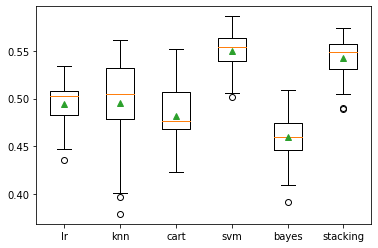

In [70]:
# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot
  
# get a stacking ensemble of models
def get_stacking():
# define the base models
    level = list()
    level.append(('lr', LogisticRegression()))
    level.append(('knn', KNeighborsClassifier()))
    level.append(('cart', DecisionTreeClassifier()))
    level.append(('svm', SVC()))
    level.append(('bayes', GaussianNB()))
# define meta learner model
    level1 = LogisticRegression()
# define the stacking ensemble
    model = StackingClassifier(estimators=level, final_estimator=level1, cv=5)
    return model
 
# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    models['stacking'] = get_stacking()
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()